In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import math
from tqdm import tqdm
from itertools import combinations
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from nilearn import plotting
# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.metrics import ave_control, modal_control
from nctpy.utils import (
matrix_normalization,
normalize_state,
normalize_weights,
)
from nctpy.plotting import set_plotting_params, reg_plot
import networkx as nx

In [2]:
A = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/A.txt')
G = nx.from_numpy_matrix(A)
print(f"The graph is {'connected' if nx.is_connected(G) else 'not connected'}.")

The graph is connected.


In [3]:
def compute_opt_control_set(A, x0, xf, c, rho, S, system=None, T=1, control_size=1, numerical_threshold=1e-8):
        """
    Computes and sort the optimal control set according to their energy.

    Args:
        A (NxN, numpy array): The adjacency matrix of structural connectivity.
        x0 (Nx1, numpy array): The initial state.
        xf (Nx1, numpy array): The target state.
        rho (float): A mixing parameter that balances the importance of different terms in the control problem.
        S (NxN, numpy array): A constraint matrix that specifies which nodes' states are constrained.
        system (str, optional): Specifies whether the system is continuous or discrete.
        c (float, optional): A scaling factor for normalizing the adjacency matrix. 
        T (float, optional): The time horizon over which control is applied. 
        control_size (int, optional): The number of nodes in the control set. 
        numerical_threshold (float, optional): Threshold for numerical errors; control sets with errors above this threshold are discarded. Defaults to 1e-8.

    Returns:
        results (list): A list of dictionaries with 'combination', 'energy', and 'error'
        e.g. results = [{'combination': comb, 'energy': energy, 'error': [error1, error2]}, ...], 
        where error1 refer to inversion error, error2 refer to reconstruction error.

    Raises:
        ValueError: If no valid combination is found that meets the numerical threshold.

    """
        
        
    results = []
    n_nodes = A.shape[0]
    all_combinations = combinations(range(n_nodes), control_size)
    num_combinations = math.comb(n_nodes, control_size)
    A_norm = matrix_normalization(A, system, c=gamma)
    valid_combination_found = False
    np.random.seed(0)
    

    for comb in tqdm(all_combinations, desc=f"Control size {control_size}", total=num_combinations):
        B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
        for i in comb:
            B[i, i] = 1

        _, control_signals, numerical_error = get_control_inputs(
            A_norm=A_norm,
            T=T,
            B=B,
            x0=x0,
            xf=xf,
            system=system,
            rho=rho,
            S=S
            
        )


        # Check numerical errors
        if numerical_error[0] <= numerical_threshold and numerical_error[1] <= numerical_threshold:
            valid_combination_found = True
            E = integrate_u(control_signals)
            energy = np.sum(E)
            results.append({'combination': comb, 'energy': energy, 'error': numerical_error})
            
            
    if not valid_combination_found:
        raise ValueError(f"No valid combination found for control size {control_size} with the given numerical threshold.")

    # Sort data by 'energy' in ascending order
    results = sorted(results, key=lambda x: x['energy'])
    
    return results

In [3]:
# balance between minimizing energy or minimizing distance from target state
rho = .2
# time to go from initial to target state
T = .7
# the number of time points the code spits out: T * 1000 + 1
nTime = 701
gamma = 4
# to try and simulate stimuluation, we're gonna weight the B matrix
B_mu = .0005
B_sigma = .00005
system = 'continuous'
S = np.eye(A.shape[0])

# initial to resting

Control size 1: 100%|█████████████████████████| 246/246 [00:42<00:00,  5.80it/s]


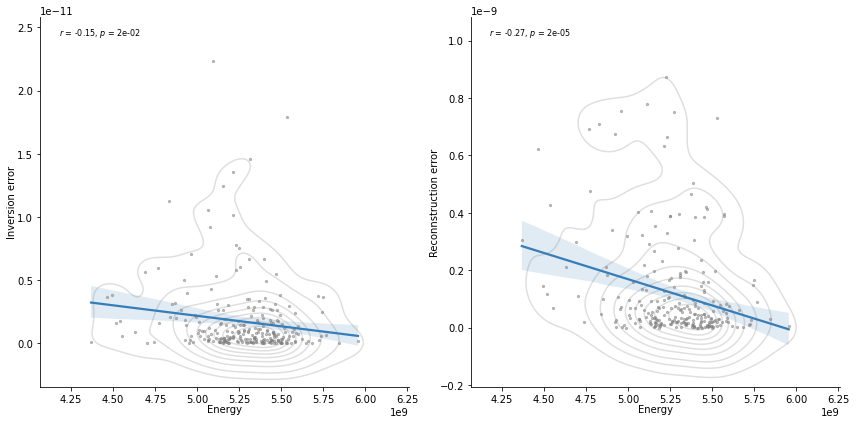

In [5]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

# results = [{'combination': comb, 'energy': energy, 'error': [error1, error2]}, ...]
results = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)


energies = np.array([result['energy'] for result in results])
errors1 = np.array([result['error'][0] for result in results])
errors2 = np.array([result['error'][1] for result in results])


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

reg_plot(x=energies, y=errors1, xlabel='Energy', ylabel='Inversion error', annotate='pearson', ax=axs[0])
reg_plot(x=energies, y=errors2, xlabel='Energy', ylabel='Reconnstruction error', annotate='pearson', ax=axs[1])

plt.tight_layout()
plt.show()

In [6]:
for result in results:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Stimulation Point: (174,), Error: [1.351592187253517e-13, 3.065540159288508e-10]
Stimulation Point: (175,), Error: [3.67235512142329e-12, 6.227239781597233e-10]
Stimulation Point: (179,), Error: [3.795835436160656e-12, 1.4640711122438066e-10]
Stimulation Point: (153,), Error: [1.6517133861680881e-12, 1.1578917731200553e-10]
Stimulation Point: (147,), Error: [1.7694776138634565e-12, 4.272877976985342e-10]
Stimulation Point: (180,), Error: [5.935424538953261e-13, 6.971602449209985e-11]
Stimulation Point: (176,), Error: [9.291777002419354e-13, 2.1122713808608432e-10]
Stimulation Point: (182,), Error: [5.672459992344469e-12, 2.9886904158026604e-10]
Stimulation Point: (170,), Error: [5.61177837442947e-14, 1.0944477752294618e-10]
Stimulation Point: (40,), Error: [1.3459035971554104e-13, 1.82287804211888e-11]
Stimulation Point: (177,), Error: [6.001622991826723e-12, 6.923715431611069e-10]
Stimulation Point: (183,), Error: [1.6367975023762502e-12, 4.749564509798549e-10]
Stimulation Point: (181

# initial to perturbed initial

In [15]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
noise_std = 0.1 * np.mean(initial_state) 
noise = np.random.normal(0, noise_std, size=initial_state.shape)
target_state = initial_state + noise
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_perturb = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)

for result in results_perturb:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Control size 1: 100%|█████████████████████████| 246/246 [00:40<00:00,  6.02it/s]

Stimulation Point: (173,), Error: [1.1810519380431555e-13, 1.64259046550287e-11]
Stimulation Point: (167,), Error: [1.9843861149568348e-13, 2.4499902863965717e-11]
Stimulation Point: (184,), Error: [2.548829600759183e-13, 1.5101055982981916e-11]
Stimulation Point: (37,), Error: [2.6116233806720266e-13, 5.459815553251994e-11]
Stimulation Point: (166,), Error: [3.0433040169098255e-13, 3.93689070586761e-10]
Stimulation Point: (157,), Error: [1.3708893831243943e-13, 5.764147333671097e-12]
Stimulation Point: (169,), Error: [8.22878894066674e-13, 6.359103385370687e-11]
Stimulation Point: (170,), Error: [4.934368383020208e-13, 1.0514665748320516e-10]
Stimulation Point: (162,), Error: [1.2899640094011278e-12, 5.449992072523496e-10]
Stimulation Point: (241,), Error: [7.193548470933074e-13, 1.6554030951393938e-10]
Stimulation Point: (163,), Error: [5.344242033604766e-13, 2.147837802196311e-11]
Stimulation Point: (40,), Error: [2.6485574417508643e-13, 2.2192354994464614e-12]
Stimulation Point: (1

In [ ]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/initial_state.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/resting_state.txt')
n_nodes = A.shape[0]
B = np.eye(n_nodes) * np.random.normal(loc=B_mu, scale=B_sigma, size=(1, n_nodes))
B[147, 147] = 1
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)
A_norm = matrix_normalization(A, system, c=gamma)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=T,
    B=B,
    x0=x0,
    xf=xf,
    system="continuous",
    rho=rho,
    S=S,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )


# 保存 control_signals (T x N)
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/control_signals_initial_to_resting(147).txt" , control_signals, delimiter=",")
# 保存 state_trajectory (T x N)
np.savetxt("/Users/shenxiaoyu/Desktop/NCT/state_trajectory_initial_to_resting(147).txt", state_trajectory, delimiter=",")


# high pain to low pain

In [16]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_pain = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 1,
)

for result in results_pain:
    print(f"Stimulation Point: {result['combination']}, Error: {result['error']}")

Control size 1: 100%|█████████████████████████| 246/246 [00:41<00:00,  5.86it/s]

Stimulation Point: (61,), Error: [1.5328615474467088e-13, 8.015683746643478e-11]
Stimulation Point: (173,), Error: [1.0228013781128107e-12, 1.1190659171666376e-12]
Stimulation Point: (167,), Error: [1.3274120581952536e-13, 3.3653032171493024e-11]
Stimulation Point: (157,), Error: [1.6771040552237076e-13, 3.538697321587734e-11]
Stimulation Point: (234,), Error: [2.04583951503646e-13, 1.2979513642444363e-10]
Stimulation Point: (37,), Error: [1.1880303024961317e-13, 9.436900822842016e-11]
Stimulation Point: (169,), Error: [7.168245366181253e-12, 2.1474344156817432e-11]
Stimulation Point: (60,), Error: [8.561056683266236e-13, 5.444697167321064e-10]
Stimulation Point: (155,), Error: [1.114468419197231e-12, 1.6834214177072088e-10]
Stimulation Point: (184,), Error: [1.4649585553211655e-13, 6.963541935957291e-12]
Stimulation Point: (171,), Error: [3.3434591543591234e-12, 2.9742626880753833e-11]
Stimulation Point: (9,), Error: [8.254533712981293e-13, 1.505825296695721e-10]
Stimulation Point: (1

# 2 simulation point

In [47]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

results_high_low_pain_2 = compute_opt_control_set(
    A=A,
    x0=x0,
    xf=xf,
    c=gamma,
    rho=rho,
    S=S,
    system="continuous",
    T=T,
    control_size= 2,
    numerical_threshold=1
)

with open('/Users/shenxiaoyu/Desktop/NCT/high_low_pain(2 point).txt', 'w') as file:
    for result in results_high_low_pain_2:
        output_line = f"Stimulation Point: {result['combination']}, Energy: {result['energy']}, Error: {result['error']}\n"
        file.write(output_line)

Control size 2: 100%|███████████████████| 30135/30135 [1:32:09<00:00,  5.45it/s]


In [4]:
class ComputeOptimizedControlEnergy():
    """This class will compute `optimised` control energy for a single control task stored in control_task.
    """

    def __init__(self, A, control_task, system=None, c=1, T=1, threshold=0.01, lr=0.01):
        """Initializes inputs to ComputeOptimizedControlEnergy
        Args:
            A (NxN, numpy array): adjacency matrix representing a structural connectome.
            control_task (dict): control task.
            system (str): string variable that determines whether A is normalized for a continuous-time system or a
                discrete-time system. options: 'continuous' or 'discrete'. default=None.
            c (int): normalization constant, default=1.
            T (float): time horizon.
            threshold (float): threshold for stopping criterion based on energy decrease.
            lr (float): learning rate for gradient descent.
        """
        self.A = A
        self.control_task = control_task
        self.system = system
        self.c = c
        self.T = T
        self.threshold = threshold
        self.lr = lr

    def _check_inputs(self):
        if self.A.shape[0] == self.A.shape[1]:
            self.n_nodes = self.A.shape[0]
        elif self.A.shape[0] != self.A.shape[1]:
            raise Exception("A matrix is not square. This routine requires A.shape[0] == A.shape[1]")
        try:
            A_norm = self.A_norm
        except AttributeError:
            self.A_norm = matrix_normalization(self.A, system=self.system, c=self.c)

    def _get_energy(self, B):
        if self.control_task['rho'] == 0:
            S = np.eye(self.n_nodes)
        else:
            S = self.control_task['S']
        _, u, _ = get_control_inputs(A_norm=self.A_norm, T=self.T, B=B,
                                     x0=self.control_task['x0'], xf=self.control_task['xf'], system=self.system,
                                     rho=self.control_task['rho'], S=S)
        E = integrate_u(u)
        E = np.sum(E)
        return E

    def _get_energy_perturbed(self, B):
        # container for perturbed energies
        E_p = np.zeros(self.n_nodes)
        # backup B
        B_bak = B.copy()
        for i in tqdm(np.arange(self.n_nodes)):
            # get B
            B_p = B_bak.copy()
            # add arbitrary amount of additional control to node i
            B_p[i, i] += 0.1
            # get the state trajectory (x_p) and the control inputs (u_p)
            E_p[i] = self._get_energy(B=B_p)
        return E_p

    def run(self):
        self._check_inputs()
        B_I = np.eye(self.n_nodes)  # B = identity
        B = B_I  # initialize with identity
        E = self._get_energy(B=B)  # get initial energy

        while True:
            E_p = self._get_energy_perturbed(B=B)  # get perturbed energy
            E_d = E_p - E  # calculate energy delta
            B_o = np.zeros((self.n_nodes, self.n_nodes))  # initialize container for optimized weights
            B_o[np.diag_indices(self.n_nodes)] = B.diagonal() - (E_d * self.lr)  # step down gradient
            B_o = B_o / sp.linalg.norm(B_o) * sp.linalg.norm(B_I)  # normalize
            E_o = self._get_energy(B=B_o)  # get optimized energy

            # check if the energy decrease is below the threshold
            if abs(E - E_o) < self.threshold:
                break

            E = E_o  # update energy
            B = B_o  # update control matrix

        self.E_opt = E
        self.B_opt = B

In [5]:
initial_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/high_pain.txt')
target_state = np.loadtxt('/Users/shenxiaoyu/Desktop/NCT/low_pain.txt')
x0 = normalize_state(initial_state)
xf = normalize_state(target_state)

learning_rate = 0.01
control_task = dict()  # initialize dict
control_task["x0"] = x0  # store initial state
control_task["xf"] = xf  # store target state
control_task["S"] = S  # store state trajectory constraints
control_task["rho"] = 1  # store rho
compute_opt_control_energy = ComputeOptimizedControlEnergy(
    A=A,
    control_task=control_task,
    system="continuous",
    c=1,
    T=1,
    threshold=1,
    lr=learning_rate
)

compute_opt_control_energy.run()

100%|█████████████████████████████████████████| 246/246 [00:50<00:00,  4.89it/s]


In [8]:
print(compute_opt_control_energy.E_opt)
print(compute_opt_control_energy.B_opt)

513.6319820921931
[[1.10509592 0.         0.         ... 0.         0.         0.        ]
 [0.         1.26981529 0.         ... 0.         0.         0.        ]
 [0.         0.         1.14814776 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.13168294 0.         0.        ]
 [0.         0.         0.         ... 0.         1.31369371 0.        ]
 [0.         0.         0.         ... 0.         0.         0.87867355]]


In [12]:
B_opt = compute_opt_control_energy.B_opt
control_weights = np.diag(B_opt)

# Create a list of tuples (node_index, control_weight)
nodes_sorted_by_weight = [(i, control_weights[i]) for i in range(len(control_weights))]
# Sort the list by control_weight in descending order
nodes_sorted_by_weight.sort(key=lambda x: x[1], reverse=True)


print("Nodes sorted by control input weight (from highest to lowest):")
for node, weight in nodes_sorted_by_weight:
    print(f"Node {node}: {weight}")

Nodes sorted by control input weight (from highest to lowest):
Node 167: 2.6941023413455154
Node 63: 2.289590979198544
Node 173: 2.200626493648324
Node 166: 2.148438599426022
Node 39: 2.119931438277676
Node 61: 2.1190316221152212
Node 157: 1.970662900544218
Node 37: 1.8806673540298575
Node 139: 1.856930369369651
Node 171: 1.8465481608101102
Node 145: 1.8420265520209416
Node 169: 1.779008032852047
Node 29: 1.6339814046831127
Node 21: 1.6335901613289543
Node 156: 1.611509401380067
Node 60: 1.59085799899638
Node 62: 1.5090221345430266
Node 25: 1.4393309265268823
Node 24: 1.3869309726272694
Node 31: 1.3775370966881513
Node 73: 1.3516703119956257
Node 131: 1.3482559838071548
Node 163: 1.3241671975186289
Node 244: 1.313693713998339
Node 232: 1.3011353492414799
Node 229: 1.2817925551100082
Node 1: 1.2698152890034173
Node 165: 1.2462657016179532
Node 228: 1.2331097971167542
Node 8: 1.2246184144580998
Node 130: 1.2092872512317663
Node 170: 1.1842163657404268
Node 6: 1.169507543681752
Node 183: 